# Simulating Spurious Association
This is a simple simulation of spurious associations based on the book [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/) chapter 5.1.

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns
import pandas as pd
import numpy as np
from causalgraphicalmodels import CausalGraphicalModel

The purpose of this simulation is to show that with a mutiple regression model it's possible to spot spurious associations.
<br>
<br>
The relationship that will be simulated will be:
* **cold -> snow**
* **cold -> heaters_on**

It snows when it's cold, and people turn on the heaters in their houses.

In [2]:
SAMP_SIZE = 100 # size of sample
np.random.seed(seed=25)

# all standardised -> mean=0, std=1
cold = stats.norm.rvs(size=SAMP_SIZE)
heaters_on = stats.norm.rvs(cold)
snow = stats.norm.rvs(cold)

# creating a pandas dataframe
d = {'cold': cold,
    'heaters_on': heaters_on,
    'snow': snow}
df = pd.DataFrame(data=d)
df.head()

,cold,heaters_on,snow
0,0.228273,-1.499381,1.580128
1,1.026890,1.790958,2.142699
2,-0.839585,-0.394271,-1.869791
3,-0.591182,-2.726758,-1.035464
4,-0.956888,0.063476,-0.899465


In [3]:
df.describe()

,cold,heaters_on,snow
count,100.000000,100.000000,100.000000
mean,-0.051501,-0.137382,-0.013803
std,1.089027,1.664283,1.462405
min,-2.594487,-4.013281,-3.744018
25%,-0.660708,-1.222513,-1.037403
50%,-0.096265,-0.176523,-0.273534
75%,0.512390,0.874226,0.923420
max,2.822756,3.707193,3.145804


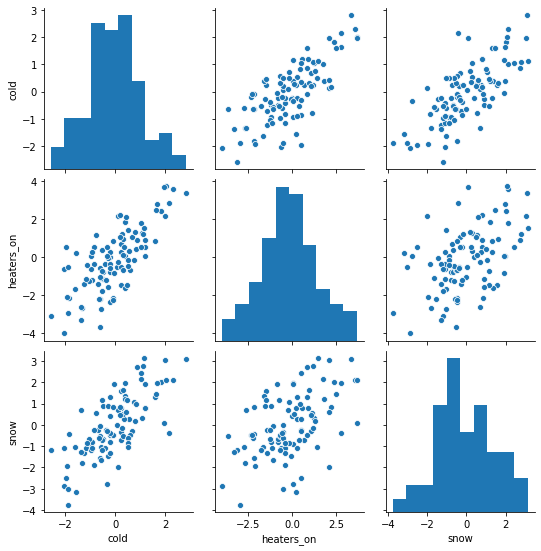

In [4]:
sns.pairplot(data=df)

We can notice by the pairplot above that **cold** and **heaters_on** seem to be correlated to **snow**.
<br>
<br>
The same can be seen on the correlation matrix bellow. However it's important to observe that the correlation between **heaters_on** and **cold** is quite high (as expected since **heaters_on** samples were drawn from **cold**).

In [5]:
df.corr()

,cold,heaters_on,snow
cold,1.000000,0.744781,0.731967
heaters_on,0.744781,1.000000,0.493779
snow,0.731967,0.493779,1.000000


### Regressing cold->snow
Regressing for the real **cold** data we can see bellow it higly correlated with **snow**, as the coeficient of **0.98** and has a small standard deviation of **0.10**.

In [6]:
with pm.Model() as spur_t:
    a = pm.Normal('a', 0, 1)
    bC = pm.Normal('bC', 0, 1)
    mu = pm.Deterministic('mu', a + bC*df['cold'])
 
    sigma = pm.Exponential('sigma', 1)
    snow = pm.Normal('snow', mu=mu, sigma=sigma, observed=df['snow'])
    
    cold_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bC, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5504.82draws/s]


In [7]:
varnames = ['~mu']
az.summary(cold_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.04,0.10,-0.14,0.23
bC,0.98,0.10,0.80,1.16
sigma,1.01,0.07,0.88,1.15


### Regressing heaters_on->snow
Regressing for the spurious **heaters_on** data we can see bellow it has still a good level of correlation, of **0.43** and a small standard deviation of **0.08**, with **snow**.

In [8]:
with pm.Model() as spur_t:
    a = pm.Normal('a', 0, 1)
    bH = pm.Normal('bH', 0, 1)
    mu = pm.Deterministic('mu', a + bH*df['heaters_on'])
    sigma = pm.Exponential('sigma', 1)
    snow = pm.Normal('snow', mu=mu, sigma=sigma, observed=df['snow'])
    
    heaters_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bH, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4900.69draws/s]


In [9]:
varnames = ['~mu']
az.summary(heaters_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.05,0.12,-0.16,0.30
bH,0.43,0.08,0.28,0.58
sigma,1.28,0.10,1.11,1.46


### Multivariate regression:   snow <- cold -> heaters_on
However when we include the variable **cold** we have a different result as shown bellow:

In [10]:
with pm.Model() as full_model:
    a = pm.Normal('a', 0, 1)
    bC = pm.Normal('bC', 0, 1)
    bH = pm.Normal('bH', 0, 1)
    mu = pm.Deterministic('mu', a + bC*df['cold'] + bH*df['heaters_on'])
    sigma = pm.Exponential('sigma', 1)
    snow = pm.Normal('snow', mu=mu, sigma=sigma, observed=df['snow'])
    
    multi_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bH, bC, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4003.63draws/s]


/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'bC'}>,
        <AxesSubplot:title={'center':'bC'}>],
       [<AxesSubplot:title={'center':'bH'}>,
        <AxesSubplot:title={'center':'bH'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

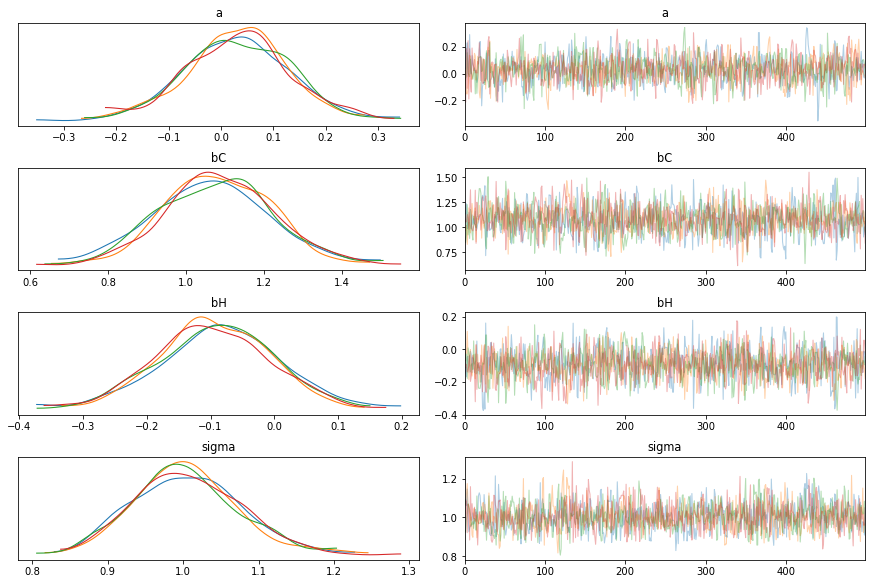

In [11]:
varnames = ['~mu']
az.plot_trace(multi_trace, var_names=varnames)

In [12]:
az.summary(multi_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.03,0.10,-0.17,0.20
bC,1.08,0.14,0.82,1.35
bH,-0.09,0.09,-0.27,0.08
sigma,1.01,0.07,0.87,1.13


By using a mutiple regression we can spot that **heaters_on**, is a spurious association to the variable **snow** as its coeficient **bH** is quite close to **0** with standard deviation of both sides of **0.09** which means it does not explain the model.
<br>
<br>
It's interesting to notice that the value of **a** is somehow close to **0**, this is because the data is standardised (mean=0, std=1), with more samples it becomes more and more closer to **0**. 
<br>
<br>
Bellow we have the forest plot for the 3 models above representing the changing of both coeficients **bC** and **bH** for the 3 models. Notice there's a slight change on the correlation of **cold** on the multivariate regression. On the other hand, the coeficient **bH** goes to **0** on the multivariate regression.

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

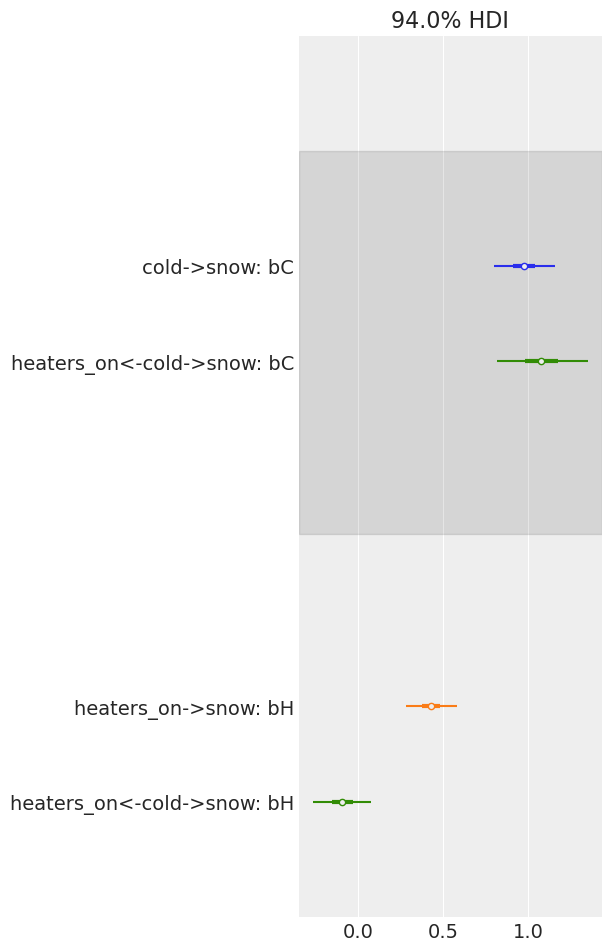

In [13]:
az.style.use("arviz-darkgrid")
az.plot_forest([cold_trace, heaters_trace, multi_trace], 
              model_names=["cold->snow", "heaters_on->snow", "heaters_on<-cold->snow"],
              var_names=["bC", "bH"],
              combined=True)

### Conclusion*: 
Once we know **cold** there's little or no additional predictive power in also knowing **heaters_on**. However, if you don't have access to **cold** then you'd definitely find value in knowing **heaters_on**.

\* freely adapted from the book

### DAG representation
We can represent the causal relationship with the following DAG(Directed Acyclic Graph):

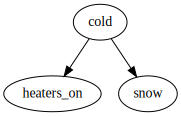

In [14]:
assoc = CausalGraphicalModel(
    nodes=["cold", "heaters_on", "snow"], edges=[("cold", "heaters_on"), ("cold", "snow")]
)

assoc.draw()

In [15]:
%load_ext watermark
%watermark -iv -v -nuw

arviz   0.10.0
seaborn 0.10.1
numpy   1.19.1
pandas  1.1.1
pymc3   3.8
last updated: Tue Nov 03 2020 

CPython 3.7.7
IPython 7.17.0
watermark 2.0.2
